# Урок 4. Uplift-моделирование

**Задание**

<br>1. Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention</br>
<br>2. Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.</br>
<br>3. Сделать разбиение набора данных не тренировочную и тестовую выборки</br>
<br>4. провести uplift-моделирование 3 способами:
- одна модель с признаком коммуникации (S-learner)
- модель с трансформацией таргета
- вариант с двумя независимыми моделями
</br>

<br>5. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей</br>

In [18]:
!./bash/hw4.sh

--2022-06-17 10:46:35--  https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ
Resolving drive.google.com (drive.google.com)... 173.194.205.100, 173.194.205.102, 173.194.205.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.205.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1fpsi44qmm8umn7l4ksr8lkjkv1nsacp/1655451975000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ [following]
--2022-06-17 10:46:36--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1fpsi44qmm8umn7l4ksr8lkjkv1nsacp/1655451975000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.187.97
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)|142.250.187.97|:443... connected.


In [19]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv('./data/data.csv', sep=',')
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.sample(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
30821,10,116.99,1,0,Urban,1,Web,1,0
42236,5,973.22,1,1,Urban,1,Phone,0,1
5571,10,130.26,1,0,Surburban,0,Phone,0,0
21986,11,29.99,1,0,Urban,1,Phone,1,0
25122,4,308.01,1,1,Urban,1,Multichannel,1,0


In [23]:
cat_feature = ['zip_code', 'channel']

In [24]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

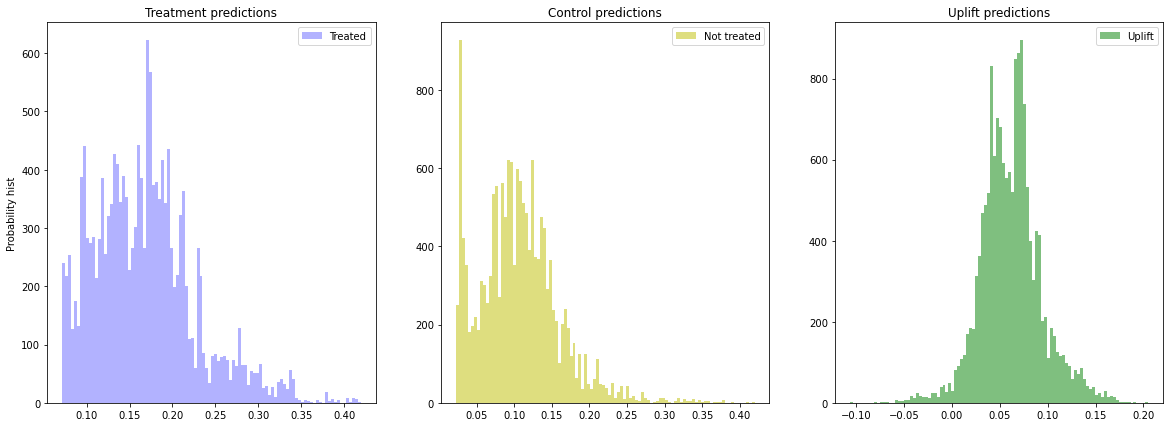

In [26]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])

tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
                                    'model': type(tm).__name__,
                                    'uplift@10%': tm_score_10,
                                    'uplift@20%': tm_score_20
                                }, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [27]:
metrics_df

,model,uplift@10%,uplift@20%
0,TwoModels,0.104,0.07436
